In [1]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, preprocess_dataset
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt

Using TensorFlow backend.
W0930 12:50:39.527405 4652570048 module_wrapper.py:137] From /Users/fumarolaf/git/Mask_RCNN/samples/car_part_segmentation/car_part.py:25: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



## Explore the dataset with the annotations for the car part classification

In [2]:
part_annotation_files = Path(
    '../../../car-damage-estimation/data/car_part/trainval/Annotations_Part/')
images_path = Path('../../../car-damage-estimation/data/VOCdevkit/VOC2010/JPEGImages/')

images_annotations_files = list(Path(part_annotation_files).glob('*.mat'))

## Prepare the datasets

In [4]:
dataset_train, dataset_val, dataset_test, parts_dict =\
    prepare_datasets(images_path, images_annotations_files, 0.7, 0.8)

100%|██████████| 10103/10103 [02:21<00:00, 71.35it/s]

train size 715, val size 102 test size 205


In [5]:
colors = visualize.generate_colormap(len(parts_dict), scaled=False)

### Check some images

In [6]:
i = 3

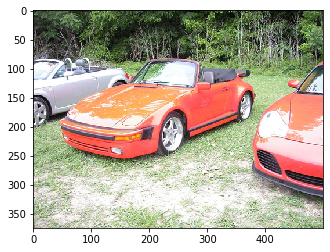

In [7]:
img = dataset_train.load_image(i)
plt.imshow(img)

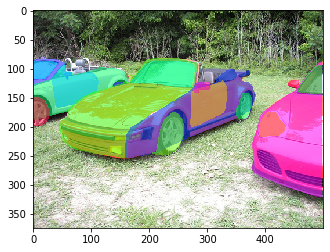

In [8]:
mask, classes = dataset_train.load_mask(i)
img_copy = img.copy()

for l in range(mask.shape[-1]):
    img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    
plt.imshow(img_copy)

In [9]:
print(parts_dict)

{'backside': 1, 'bliplate': 2, 'door_1': 3, 'door_2': 4, 'door_3': 5, 'fliplate': 6, 'frontside': 7, 'headlight_1': 8, 'headlight_2': 9, 'headlight_3': 10, 'headlight_4': 11, 'headlight_5': 12, 'headlight_6': 13, 'leftmirror': 14, 'leftside': 15, 'rightmirror': 16, 'rightside': 17, 'roofside': 18, 'wheel_1': 19, 'wheel_2': 20, 'wheel_3': 21, 'wheel_4': 22, 'wheel_5': 23, 'window_1': 24, 'window_2': 25, 'window_3': 26, 'window_4': 27, 'window_5': 28, 'window_6': 29, 'window_7': 30}


In [10]:
with open('./parts_idx_dict.json', 'w') as f:
    json.dump(parts_dict, f)

In [11]:
!cat parts_idx_dict.json

{"backside": 1, "bliplate": 2, "door_1": 3, "door_2": 4, "door_3": 5, "fliplate": 6, "frontside": 7, "headlight_1": 8, "headlight_2": 9, "headlight_3": 10, "headlight_4": 11, "headlight_5": 12, "headlight_6": 13, "leftmirror": 14, "leftside": 15, "rightmirror": 16, "rightside": 17, "roofside": 18, "wheel_1": 19, "wheel_2": 20, "wheel_3": 21, "wheel_4": 22, "wheel_5": 23, "window_1": 24, "window_2": 25, "window_3": 26, "window_4": 27, "window_5": 28, "window_6": 29, "window_7": 30}

## Image Augmentation

An example of image augmentation applied to the images

In [12]:
import imgaug as ia
import imgaug.augmenters as iaa

In [13]:
image = img
image_mask = mask

In [14]:
segmap = ia.SegmentationMapOnImage(mask, shape=image.shape, nb_classes=len(parts_dict))

In [15]:
augmentation = iaa.OneOf([
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.Affine(scale=(1., 2.5), rotate=(-90, 90), shear=(-16, 16), 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.Alpha((0.0, 1.0), iaa.Grayscale(1.0)),
    iaa.LogContrast(gain=(0.6, 1.4)),
    iaa.PerspectiveTransform(scale=(0.01, 0.15)),
    iaa.Clouds(),
    iaa.Noop(),
])

In [16]:
# Augment images and heatmaps.
images_aug = []
segmaps_aug = []
updates = []
for _ in range(10):
    augmentation_det = augmentation.to_deterministic()
    images_aug.append(augmentation_det.augment_image(image))
    segmaps_aug.append(augmentation_det.augment_segmentation_maps([segmap])[0])

In [17]:
cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                      # column 1
    cells.append(segmap.draw_on_image(image))                # column 2
    cells.append(image_aug)                                  # column 3
    cells.append(segmap_aug.draw_on_image(image_aug))        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2]))  # column 5

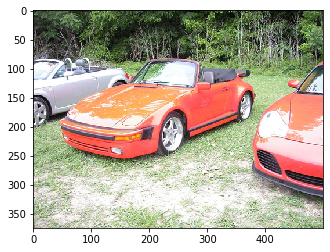

In [18]:
grid_image = ia.draw_grid(cells, cols=5)
plt.imshow(img)

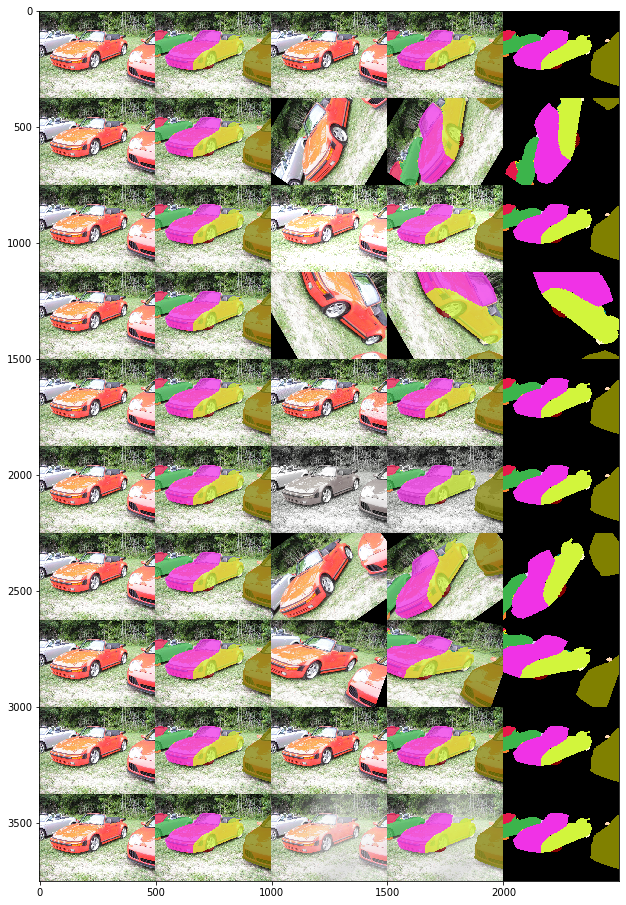

In [19]:
fig = plt.figure(figsize=(16,16))
ax = plt.subplot()
ax.imshow(grid_image)